In [122]:
import openai
from openai.types import Completion, CompletionChoice, CompletionUsage
import os
import requests

%reload_ext autoreload
from Setup_Functions import *
from Class_Structures import Room, Object

bedroom = create_room(4, 6)
create_fixed_object(bedroom, 'window', 2, 0.1, 'north', position = 0.5)
create_fixed_object(bedroom, 'door', 0.9, 0.1, 'east', position = 0.1)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'west', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'east', position = 0.8)
bedroom.draw()


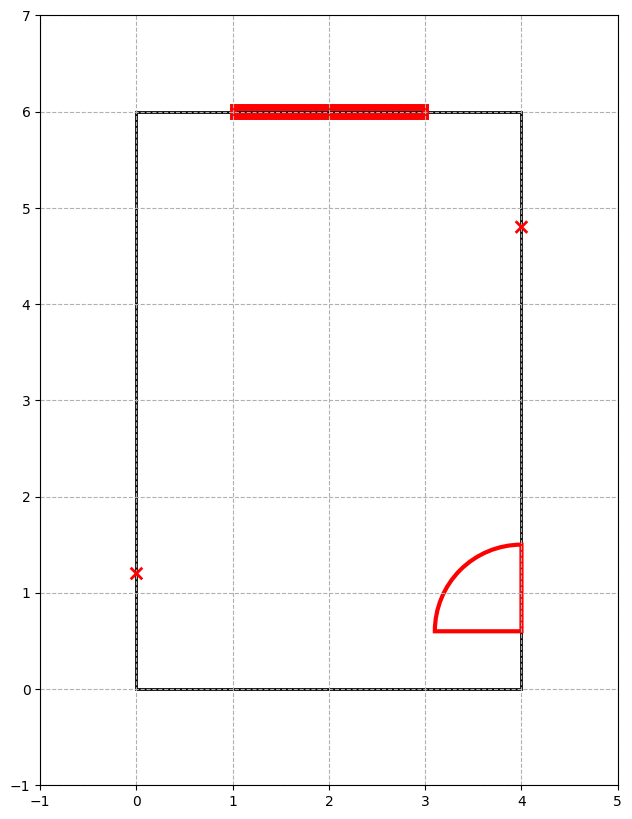

In [112]:
client = openai.Client(api_key = None)
# If you're setting the API key directly in your script, uncomment the next line 

def room_setup(scene_descriptor, api_key = None):
    url = 'https://api.openai.com/v1/chat/completions'
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Content-Type': 'application/json',
            }
    
    # Read the contents of the .py file
    file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
    with open(file_path, 'r') as file:
        file_contents = file.read()

    prompt1 = "I am designing the layout for" + scene_descriptor + ". Please give me the dimensions of the room,"
    prompt1 += " as well as the number of windows, doors, and socket. For each window, door, and socket tell me the dimensions (in meters),"
    prompt1 += " which wall it should be on, as well as where on the wall it should be (this is a value between 0 and 1 determining how far along the wall it should be). Here is an example for a room and window set up: "
    prompt1 += "{Room: width = 5,  length = 6}, {Object type: window, width = 1, length = 0.1, wall = south, position = 3}, etc." 
    prompt1 += "The windows and doors should all have length 0.1. Ensure that every object has dimensions, position, and wall. "
    prompt1 += "No other text please. Just the list with no commentary or explanation."
    response1 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt1}],
        max_tokens=500
    )
    objects = response1.choices[0].message.content.split("}, {")


    prompt2 = f"I am going to give you a set of functions that are used to create a room and put objects in it. The functions are as follows:"
    prompt2 += "\n\n{file_contents}\n\n"
    prompt2 += f"I now want, for each element in this list: {objects}, with room descriptor:" + scene_descriptor + ", for you to translate it into a function call using the functions I gave you above."
    prompt2 += " For example, given the room descriptor 'a small kitchen' as well as the list: "
    prompt2 += "{Room: width = 5,  length = 6}, {Object type: window, Number: 1,  width = 1, length = 0.1, wall = south, position = 0.3}, the output would be:"
    prompt2 += "kitchen = create_room(5, 6), create_fixed_object(kitchen, 'window', 1, 0.1, 'south', position = 0.3), kitchen.draw()."
    prompt2 += " Return only the python script. No other text. Please ensure the correct number of inputs are given for each function."

    # Define the request payload
    data = {
        "model": "gpt-4",
        "messages": [
            {"role": "user", "content": prompt2}
        ]
    }
    
    # Make the API call
    response2 = requests.post(url, headers=headers, json=data)  
    # Check the response
    if response2.status_code == 200:
        response_data2 = response2.json()
        print(response_data2['choices'][0]['message']['content'])
    else:
        print('Failed to get a response')
        print(response2.text)

    exec(response_data2['choices'][0]['message']['content'])

    return response1, response2

scene_descriptor = 'a bedroom for a teenager. The room is 4 meters wide and 6 meters long. There is one big window, 1 door, and 2 electrical plugs.'   
response1, response2 = room_setup(scene_descriptor)

In [114]:
url = 'https://api.openai.com/v1/chat/completions'
headers = {
    'Authorization': f'Bearer {api_key}',
    'Content-Type': 'application/json',
         }
    
# Read the contents of the .py file
file_path = '/Users/gabriellelittlefair/Documents/GitHub/MSc Project/DSL/Setup_Functions.py'
with open(file_path, 'r') as file:
    file_contents = file.read()


prompt3 = "Interior designers suggest that rooms should have distinct regions in them for different functions. Given the description:"
prompt3 += scene_descriptor
prompt3 += ", what regions should this room have? Pick a reasonable number of these for this room (ensure that the most important are included)"
prompt3 += " and return them in a simple list. For example if the scene description was 'An open plan kitchen dining room', the output would be "
prompt3 += "'cooking region, dining region, cleaning region' etc. Please give no other text."

response3 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt3}],
        max_tokens=500
    )

print(response3.choices[0].message.content)

prompt4 = "For each region in the room described as: " + scene_descriptor + "with regions: " + response3.choices[0].message.content + ", give me all of the constraints/considerations on its position within the room."
prompt4 += " These constraints should depend on the physical features of the room like the windows, doors, plugs, etc."
prompt4 += " They should also depend on the other regions. For example, the constraints might be something like"
prompt4 += " 'the cooking region should be near the dining region' or 'the sleeping region should have a plug in it'"
prompt4 += " or 'the storage region should be against a wall'. There are many options. Return a list of these, and keep each"
prompt4 += " constraint/consideration short and simple, but make sure that you include all of the necessary considerations for"
prompt4 += " functionality as well as any design princples you think are important. Give no other text, only the list. Remove any reasoning"
prompt4 += " or explanation for the constraint/consideration. Instead of 'Sleeping region should be near an electrical plug for a bedside lamp or charging devices'"
prompt4 += " just say 'Sleeping region should be near a plug'."

response4 = client.chat.completions.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": prompt4}],
        max_tokens=500
    )

prompt5 = "Given the room so far: " + response2.json()['choices'][0]['message']['content'] + ", and the regions: " + response3.choices[0].message.content
prompt5 += " Using the functions in the script, initialise each region. For example 'eating region' might output 'region_setup(kitchen, 'eating')."
prompt5 += " End with something like kitchen.draw(draw_regions = True). No other text please, only the python script."
 # Define the request payload
data = {
    "model": "gpt-4",
    "messages": [
            {"role": "user", "content": prompt5}
            ]
    }
    
# Make the API call
response5 = requests.post(url, headers=headers, json=data)  
# Check the response
if response5.status_code == 200:
    response_data5 = response5.json()
    print(response2.json()['choices'][0]['message']['content'] + '\n' + response_data5['choices'][0]['message']['content'])
else:
    print('Failed to get a response')
    print(response5.text)
# print(response4.choices[0].message.content)



sleeping region, study region, storage region, relaxation region
bedroom = create_room(4, 6)
create_fixed_object(bedroom, 'window', 2, 0.1, 'north', position = 0.5)
create_fixed_object(bedroom, 'door', 0.9, 0.1, 'east', position = 0.1)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'west', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'east', position = 0.8)
bedroom.draw()
region_setup(bedroom, 'sleeping')
region_setup(bedroom, 'study')
region_setup(bedroom, 'storage')
region_setup(bedroom, 'relaxation')
bedroom.draw(draw_regions = True)


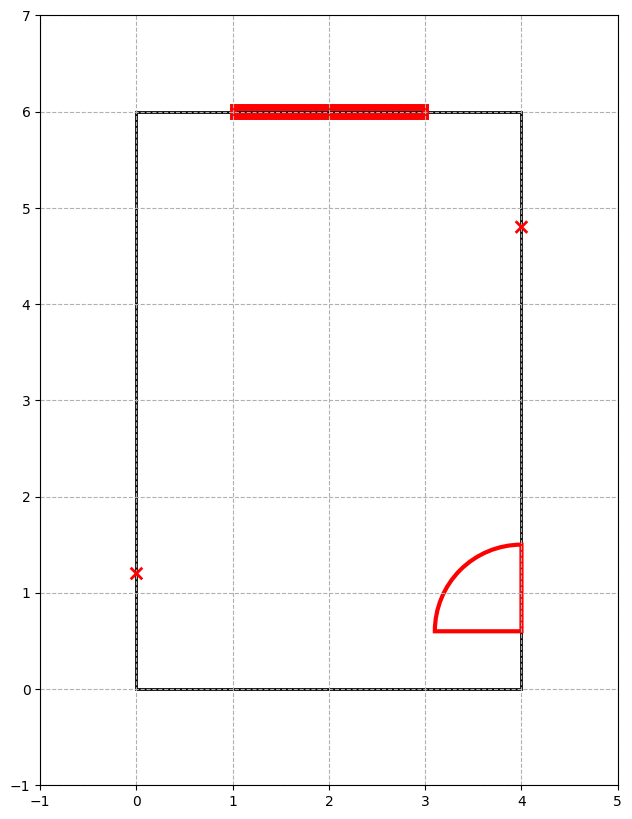

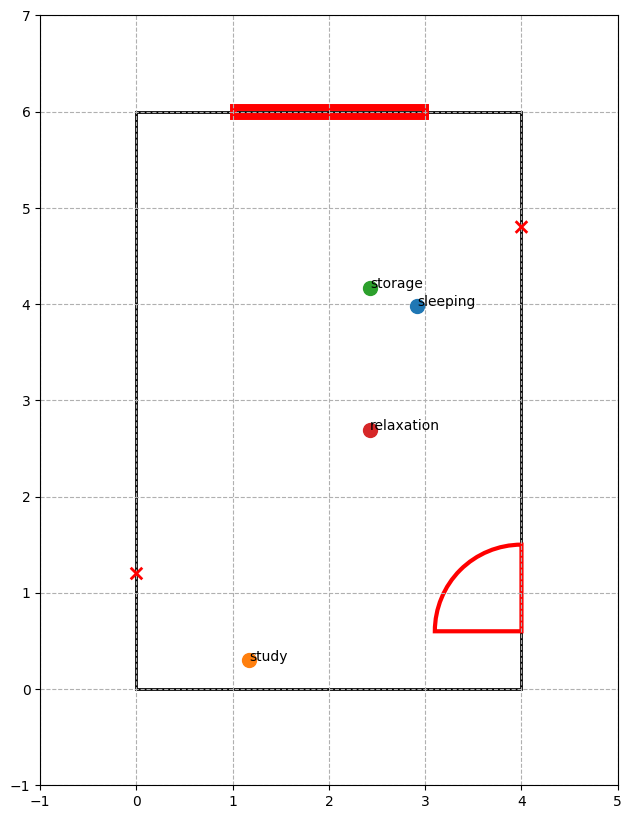

In [123]:
bedroom = create_room(4, 6)
create_fixed_object(bedroom, 'window', 2, 0.1, 'north', position = 0.5)
create_fixed_object(bedroom, 'door', 0.9, 0.1, 'east', position = 0.1)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'west', position = 0.2)
create_fixed_object(bedroom, 'socket', 0.1, 0.1, 'east', position = 0.8)
bedroom.draw()
region_setup(bedroom, 'sleeping')
region_setup(bedroom, 'study')
region_setup(bedroom, 'storage')
region_setup(bedroom, 'relaxation')
bedroom.draw(draw_regions = True)